#### Create score distribution exhibits for CIS189.



In [4]:

from random import sample
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Configuration ----------------------------------------------------------------

csv_path = "G:/My Drive/CIS189/Spring-2024-CIS189-Grades.csv"
module = 8

# ------------------------------------------------------------------------------

dfall = pd.read_csv(csv_path)

df = dfall[dfall.module==module].reset_index(drop=True)

print(df.shape)



(52, 7)


In [5]:


dfassign = df[["module", "assignment", "desc", "possible"]].drop_duplicates()

# Get number of NAs for current module assignments. 
dfna = (
    df
    .groupby(["module", "assignment"])
    .count()
    .rsub(df.groupby("assignment").size(), axis=0)["grade"]
    .reset_index(drop=False)
    .rename({"grade": "missing"}, axis=1)
    )

# Merge dfassin with dfna. 
dfassign = dfassign.merge(dfna, on=["module", "assignment"], how="left")

dfassign.head()


,module,assignment,desc,possible,missing
0,8,1,set assignment,5.0,0
1,8,2,dictionary update,10.0,0
2,8,3,selection using dictionary,10.0,0
3,8,4,search and sort array,10.0,0


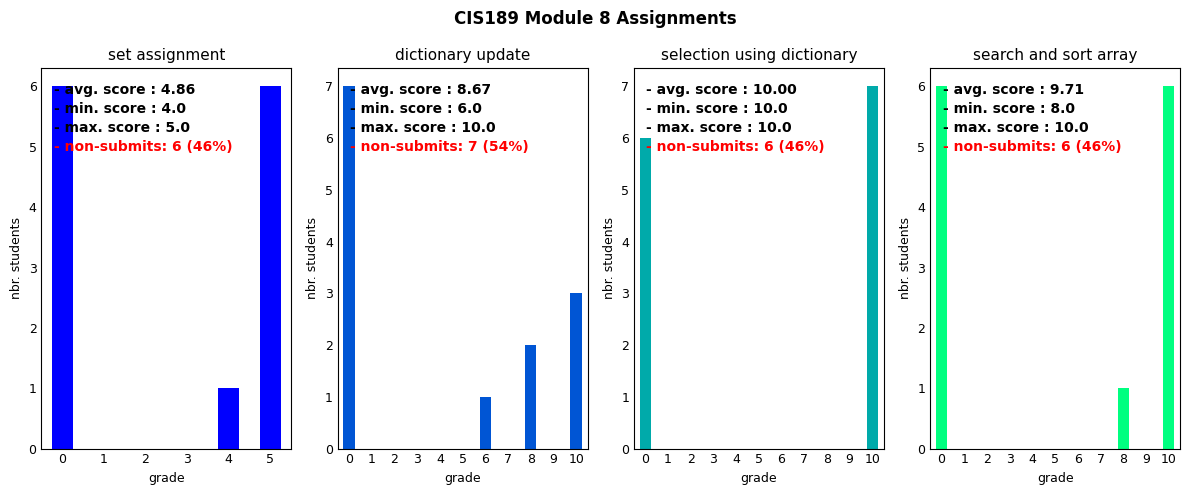

In [6]:

# color = "#E02C70"
cmap = "winter" #"gist_rainbow" #"winter"


n_facets = dfassign.shape[0]
fcolors = mpl.colormaps.get_cmap(cmap)
colors_rgba = [fcolors(ii) for ii in np.linspace(0, 1, n_facets)]
colors_hex = [mpl.colors.to_hex(ii, keep_alpha=False) for ii in colors_rgba]


fig, ax = plt.subplots(1, n_facets, figsize=(12, 5.0), sharey=False, sharex=False, tight_layout=True) 

for ii, color in enumerate(colors_hex):
    module = dfassign.at[ii, "module"]
    assign = dfassign.at[ii, "assignment"]
    desc = dfassign.at[ii, "desc"]
    possible = dfassign.at[ii, "possible"]
    nbr_students = df[(df.module==module) & (df.assignment==assign)].shape[0]
    dfgrades = pd.DataFrame(np.arange(0, possible + 1, dtype=int), columns=["grade"])
    gg = df[df.assignment==assign].fillna(0).groupby("grade", as_index=False).size()
    gg = dfgrades.merge(gg, on="grade", how="left").fillna(0).rename({"size": "n"}, axis=1)
    zs = int(gg[gg.grade==0]["n"].item())
    dfavg = gg[gg.grade!=0]
    avg_score = (dfavg.grade * dfavg.n).sum() / dfavg.n.sum()
    min_score = df[(df.assignment==assign) & (df.grade>0)]["grade"].min().item()
    max_score = df[df.assignment==assign].dropna(how="any")["grade"].max()
    gg = gg.assign(grade=gg["grade"].astype(str), n=gg["n"].astype(int))
    gg.plot.bar(ax=ax[ii], color=color)
    
    ax[ii].set_title(f"{desc}", fontsize=11, weight="normal")
    ax[ii].set_xticklabels(gg["grade"].values, rotation=0)
    ax[ii].set_xlabel("grade", fontsize=9)
    ax[ii].set_ylabel("nbr. students", fontsize=9)
    ax[ii].tick_params(axis="x", which="major", direction='in', labelsize=9)
    ax[ii].tick_params(axis="y", which="major", direction='in', labelsize=9)
    ax[ii].xaxis.set_ticks_position("none")
    ax[ii].yaxis.set_ticks_position("none")

    # ax[ii].grid(True)   
    # ax[ii].set_axisbelow(True) 
    missing = int(gg[gg.grade=="0"]["n"].item())
    prop_missing = missing / nbr_students
    avg_desc = f"- avg. score : {avg_score:.2f}"
    min_desc = f"- min. score : {min_score:.1f}"
    max_desc = f"- max. score : {max_score:.1f}"
    na_desc  = f"- non-submits: {missing} ({prop_missing:.0%})"

    ax[ii].annotate(
        avg_desc, xy=(.05, .925), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=10, rotation=0, weight="bold", color="#000000"
        ) 
    ax[ii].annotate(
        min_desc, xy=(.05, .875), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=10, rotation=0, weight="bold", color="#000000"
        ) 
    ax[ii].annotate(
        max_desc, xy=(.05, .825), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=10, rotation=0, weight="bold", color="#000000"
        ) 
    ax[ii].annotate(
        na_desc, xy=(.05, .775), xycoords="axes fraction", ha="left", va="bottom", 
        fontsize=10, rotation=0, weight="bold", color="#FF0000"
        ) 
    ax[ii].get_legend().remove()


plt.suptitle(f"CIS189 Module {module} Assignments", weight="bold", size=12)
plt.show()
